# Exercise 3
Tackle the Titanic dataset (https://www.kaggle.com/c/titanic).

In [44]:
from __future__ import division, print_function

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
import matplotlib

%matplotlib inline
matplotlib.style.use('seaborn')

In [3]:
RANDOM_STATE_SEED = 2
DATASET_DIR = 'datasets'

def load_data(filename):
    file_location = os.path.join(DATASET_DIR, filename)
    return pd.read_csv(file_location)

df = load_data('titanic.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As we can see above, we are missing two 'embarked' values, some 'age' values as well as most of the 'cabin' values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111d5e750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1152c1590>]], dtype=object)

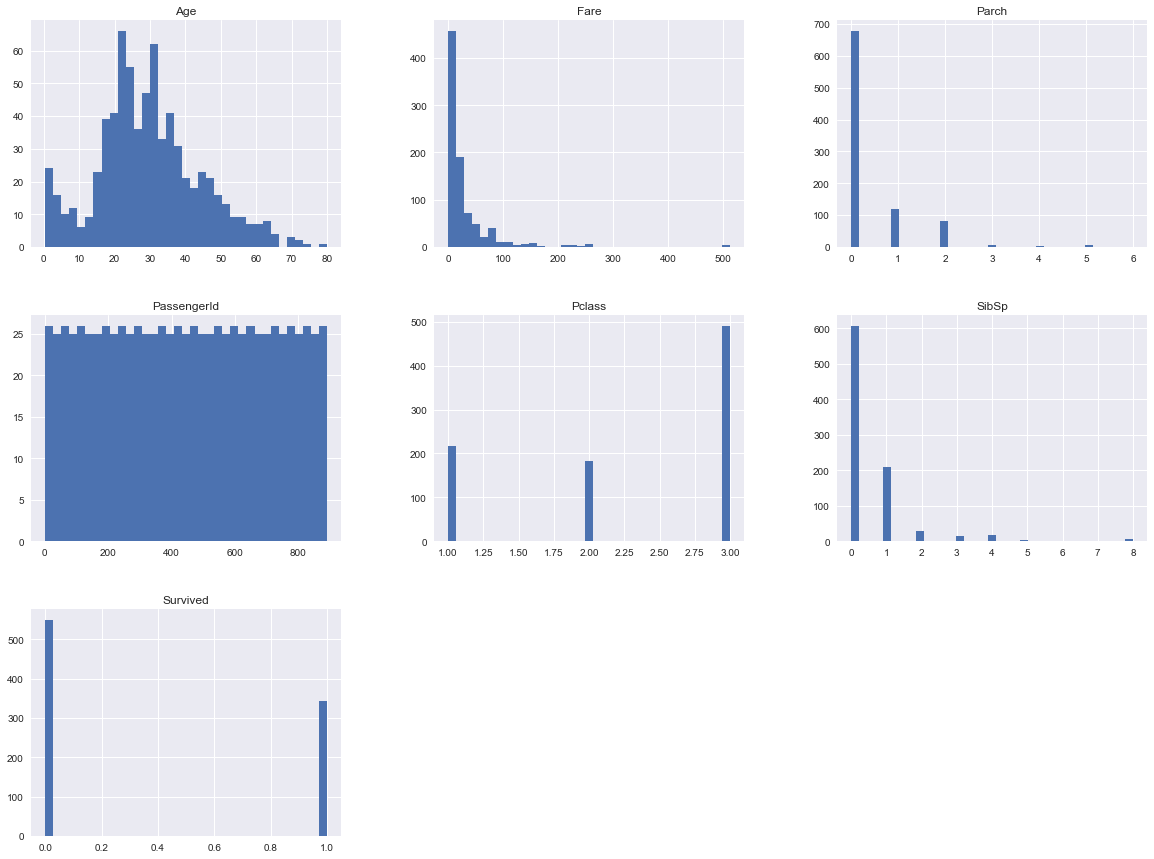

In [6]:
df.hist(bins=35, figsize=(20,15))

In order to create the train and test sets we will use stratified sampling, so we can avoid biased results:

In [74]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE_SEED)
for train_index, test_index in split.split(df, df['Survived']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [25]:
X_train = train_set.loc[:, train_set.columns != 'Survived']
y_train = train_set.loc[:, 'Survived']
X_test = test_set.loc[:, test_set.columns != 'Survived']
y_test = test_set.loc[:, 'Survived']

## Data cleaning

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler

In [9]:
class DataFrameLabelEncoder():
    def __init__(self, columns_to_encode):
        self.columns = columns_to_encode
        self.encoders = []
    
    def fit(self, X, y=None):
        if self.encoders:
            return self
        
        for column in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[column])
            self.encoders.append((column, encoder))
        return self
        
    def transform(self, X, y=None):
        encoded_df = []
        for col_name, encoder in self.encoders:
            encoded_df.append(encoder.transform(X[col_name]))
        return np.asarray(encoded_df).transpose()
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [10]:
class DataframeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns].as_matrix()

In [11]:
numerical_columns = ['Age', 'Fare']
columns_to_encode = ['Sex', 'Embarked']
remaining_columns = ['Pclass', 'SibSp', 'Parch']

num_pipeline = Pipeline([
    ('selector', DataframeSelector(numerical_columns)),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler())
])
encoder = DataFrameLabelEncoder(columns_to_encode)
remaining_col_selector = DataframeSelector(remaining_columns)


preprocessing_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('encoder', encoder),
    ('rem_col_selector', remaining_col_selector)
])

X_train = preprocessing_pipeline.fit_transform(X_train)

## Training a model
In this case we will try to use a random forest classifier:

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

rnd_forest_clf = RandomForestClassifier()
y_train_pred = cross_val_predict(rnd_forest_clf, X_train, y_train, cv=5)
y_train_prob = cross_val_predict(rnd_forest_clf, X_train, y_train, cv=5, method='predict_proba')

y_train_prob is a 2d array containing the 'probability' that a person has survived and the probability that it hasn't survived, for each person in the training set. We only need the probability that a person has survived (second column of the matrix), so we will get rid of the first column. Furthermore, the first column can be infered from the second one (and viceversa):

In [112]:
y_train_prob[:5]

array([[ 0.8       ,  0.2       ],
       [ 0.9       ,  0.1       ],
       [ 0.4       ,  0.6       ],
       [ 0.96666667,  0.03333333],
       [ 0.25833333,  0.74166667]])

In [ ]:
y_train_prob = y_train_prob[:, 1]

Utility functions to measure the performance of the model. Most of them are already implemented in scikit learn, so there is no need to implement it ourselves. I just implemented them here to review these concepts:

In [106]:
from sklearn.metrics import precision_recall_curve


def get_recall(y, y_predicted):
    true_positives = np.sum(np.logical_and(y == y_predicted, y == 1))
    false_negatives = np.sum(np.logical_and(y != y_predicted, y_predicted == 0))
    return true_positives / (true_positives + false_negatives)    

def get_precision(y, y_predicted):
    true_positives = np.sum(np.logical_and(y == y_predicted, y == 1))
    false_positives = np.sum(np.logical_and(y != y_predicted, y_predicted == 1))
    return true_positives / (true_positives + false_positives)

def get_accuracy(y, y_predicted):
    return np.sum(y_train_pred == y_train) / y_train.shape[0]

def get_f1_score(y, y_predicted):
    recall = get_recall(y, y_predicted)
    precision = get_precision(y, y_predicted)
    return 2 * (precision * recall) / (precision + recall)

def plot_precision_recall_vs_thresholds(y, y_probabilities):
    precisions, recalls, thresholds = precision_recall_curve(y, y_probabilities)
    plt.plot(thresholds, recalls[:-1], 'm:', label="Recall")
    plt.plot(thresholds, precisions[:-1], 'c-.', label="Precision")
    plt.xlabel("Threshold")
    plt.legend()
    plt.ylim([0, 1])
    plt.plot()


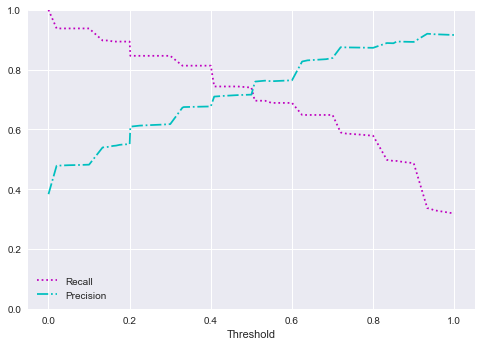

In [107]:
plot_precision_recall_vs_thresholds(y_train, y_train_prob)